In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import lightgbm as lgb
import shap

In [2]:
df = pd.read_csv("feature_engineered_master.csv")  # adjust path if needed

TARGET_COL = "sales_r12m"
GROUP_COL  = "mall_id"  # used for GroupKFold (don’t leak mall patterns)

df = df.dropna(subset=[TARGET_COL]).copy()
y = np.log1p(df[TARGET_COL].values)
groups = df[GROUP_COL].values

In [3]:
DROP_COLS = [
    TARGET_COL,
    # identifiers (usually drop)
    "store_id", "unit_id", "block_id", GROUP_COL,
    # add any obvious leakage / target-derived columns here
    # e.g. "sales_last_12m", "revenue_r12m", etc. if they exist
]

DROP_COLS = [c for c in DROP_COLS if c in df.columns]
X = df.drop(columns=DROP_COLS).copy()

cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print("X shape:", X.shape)
print("num cols:", len(num_cols), "| cat cols:", len(cat_cols))

X shape: (3609, 15)
num cols: 8 | cat cols: 7


In [4]:
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

In [5]:
gkf = GroupKFold(n_splits=5)
train_idx, val_idx = next(gkf.split(X, y, groups=groups))  # first fold

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

In [7]:
# 1) Fit preprocessor FIRST (so we can transform eval_set)
preprocess.fit(X_train)

X_train_trans = preprocess.transform(X_train)
X_val_trans   = preprocess.transform(X_val)

# 2) Fit LightGBM on transformed matrices with early stopping
lgbm = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train_trans, y_train,
    eval_set=[(X_val_trans, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

# 3) For convenience, keep a "model" object that includes preprocessing
from sklearn.pipeline import Pipeline
model = Pipeline(steps=[("preprocess", preprocess), ("lgbm", lgbm)])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1657
[LightGBM] [Info] Number of data points in the train set: 2881, number of used features: 92
[LightGBM] [Info] Start training from score 11.873930


In [8]:
pred_val = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2 = r2_score(y_val, pred_val)

print("Val RMSE (log):", rmse)
print("Val R2:", r2)


Val RMSE (log): 0.5055518812571643
Val R2: 0.8439636531016539


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
def get_feature_names(preprocess: ColumnTransformer):
    # sklearn >= 1.0 supports get_feature_names_out
    return preprocess.get_feature_names_out()

feat_names = get_feature_names(model.named_steps["preprocess"])
len(feat_names), feat_names[:10]


(483,
 array(['store_code', 'retailer_code', 'gla', 'total_costs_r12m',
        'sales_per_cost', 'has_financials', 'sri_score', 'has_sri',
        'block_type_CELL', 'block_type_KIOSK'], dtype=object))

In [10]:
booster = model.named_steps["lgbm"].booster_

imp_gain = booster.feature_importance(importance_type="gain")
imp_split = booster.feature_importance(importance_type="split")

fi = pd.DataFrame({
    "feature": feat_names,
    "importance_gain": imp_gain,
    "importance_split": imp_split,
}).sort_values("importance_gain", ascending=False)

fi.head(20)


,feature,importance_gain,importance_split
2,gla,31625.149574,3553
3,total_costs_r12m,17243.306539,3252
4,sales_per_cost,10694.194803,2593
0,store_code,8475.484620,3181
1,retailer_code,2878.261271,3454
478,gla_category_SMALL UNITS,2260.090907,57
476,gla_category_LARGE UNITS,642.238952,54
326,bl2_label_Imaterial services,455.597182,77
293,bl1_label_Health & Beauty,430.473228,202
6,sri_score,315.263442,717


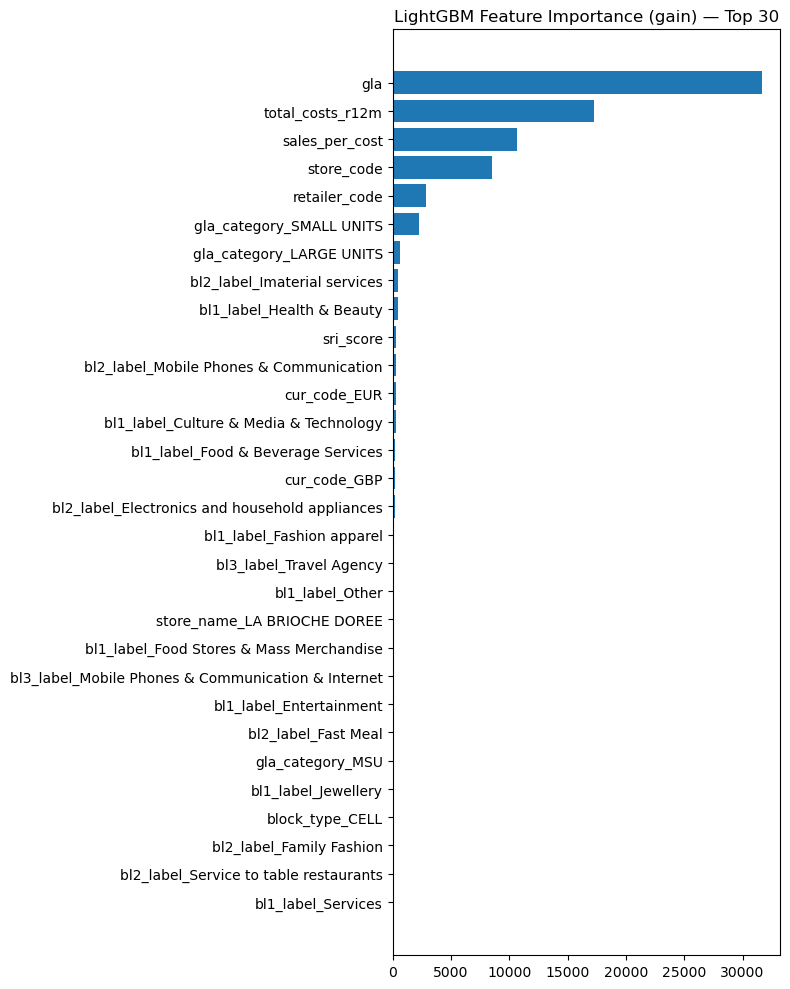

In [11]:
top_n = 30
fi_top = fi.head(top_n).iloc[::-1]

plt.figure(figsize=(8, 10))
plt.barh(fi_top["feature"], fi_top["importance_gain"])
plt.title(f"LightGBM Feature Importance (gain) — Top {top_n}")
plt.tight_layout()
plt.show()


In [12]:
X_val_trans = model.named_steps["preprocess"].transform(X_val)

perm = permutation_importance(
    model.named_steps["lgbm"],
    X_val_trans,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

pi = pd.DataFrame({
    "feature": feat_names,
    "perm_importance": perm.importances_mean,
    "perm_std": perm.importances_std,
}).sort_values("perm_importance", ascending=False)

pi.head(20)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/

,feature,perm_importance,perm_std
3,total_costs_r12m,0.490767,0.015275
4,sales_per_cost,0.384802,0.012512
2,gla,0.285786,0.021359
0,store_code,0.140614,0.017457
334,bl2_label_Mobile Phones & Communication,0.024917,0.001103
293,bl1_label_Health & Beauty,0.022478,0.006907
479,cur_code_EUR,0.018964,0.009511
326,bl2_label_Imaterial services,0.014695,0.001654
1,retailer_code,0.008875,0.006032
285,bl1_label_Culture & Media & Technology,0.008130,0.001883


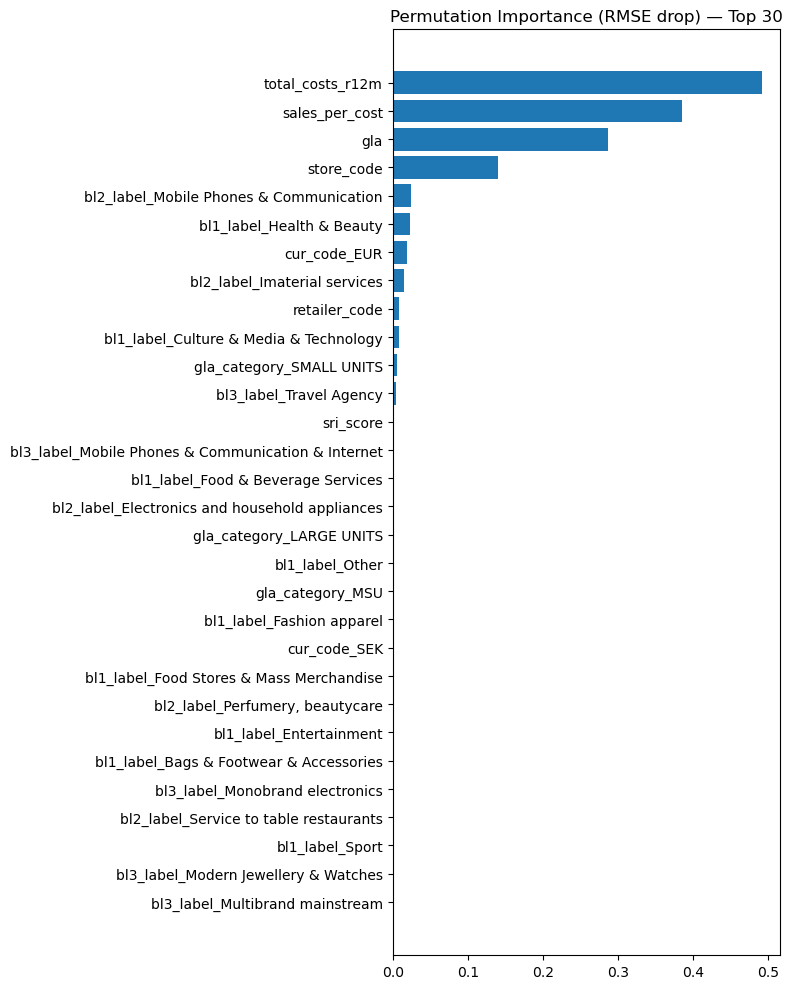

In [13]:
top_n = 30
pi_top = pi.head(top_n).iloc[::-1]

plt.figure(figsize=(8, 10))
plt.barh(pi_top["feature"], pi_top["perm_importance"])
plt.title(f"Permutation Importance (RMSE drop) — Top {top_n}")
plt.tight_layout()
plt.show()

In [14]:
X_train_trans = model.named_steps["preprocess"].transform(X_train)
X_val_trans   = model.named_steps["preprocess"].transform(X_val)

explainer = shap.TreeExplainer(model.named_steps["lgbm"])
shap_values = explainer.shap_values(X_val_trans)


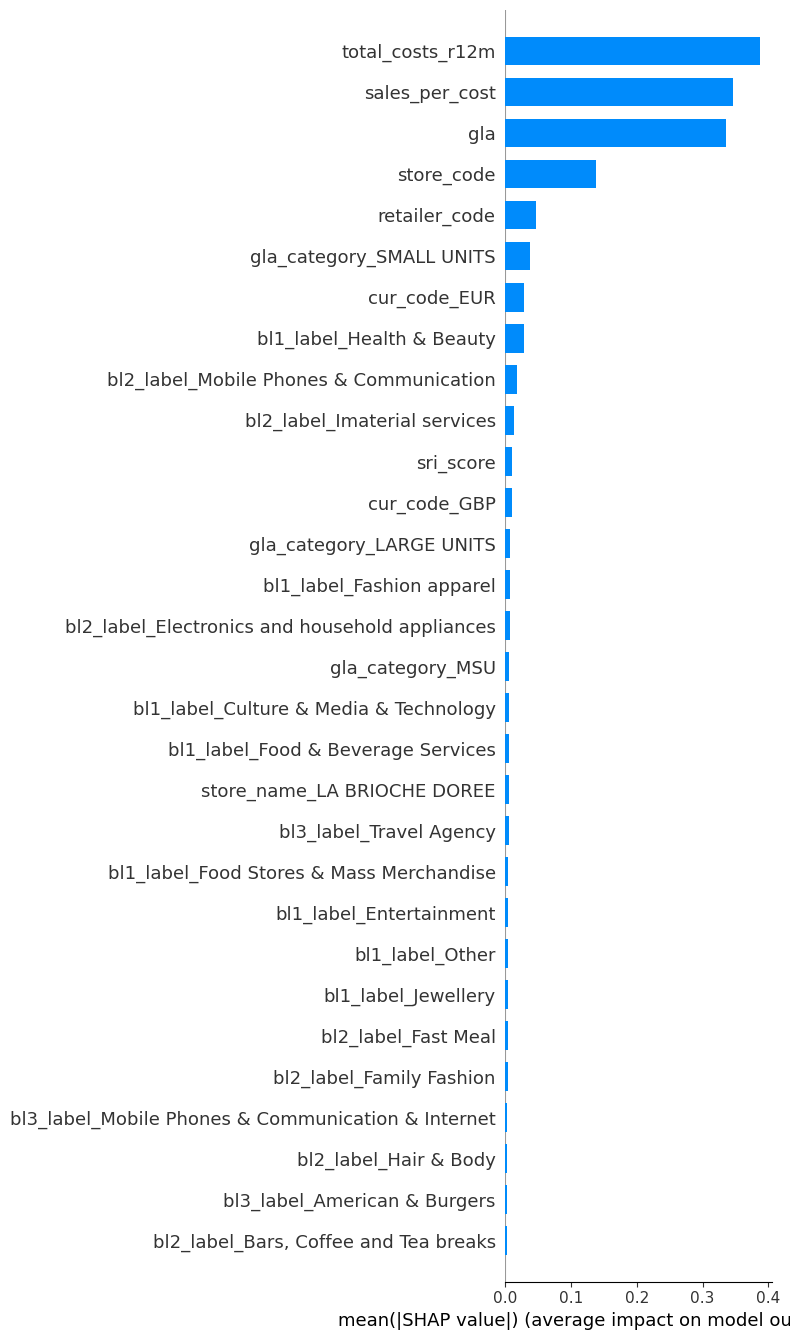

In [15]:
shap.summary_plot(
    shap_values,
    X_val_trans,
    feature_names=feat_names,
    plot_type="bar",
    max_display=30
)

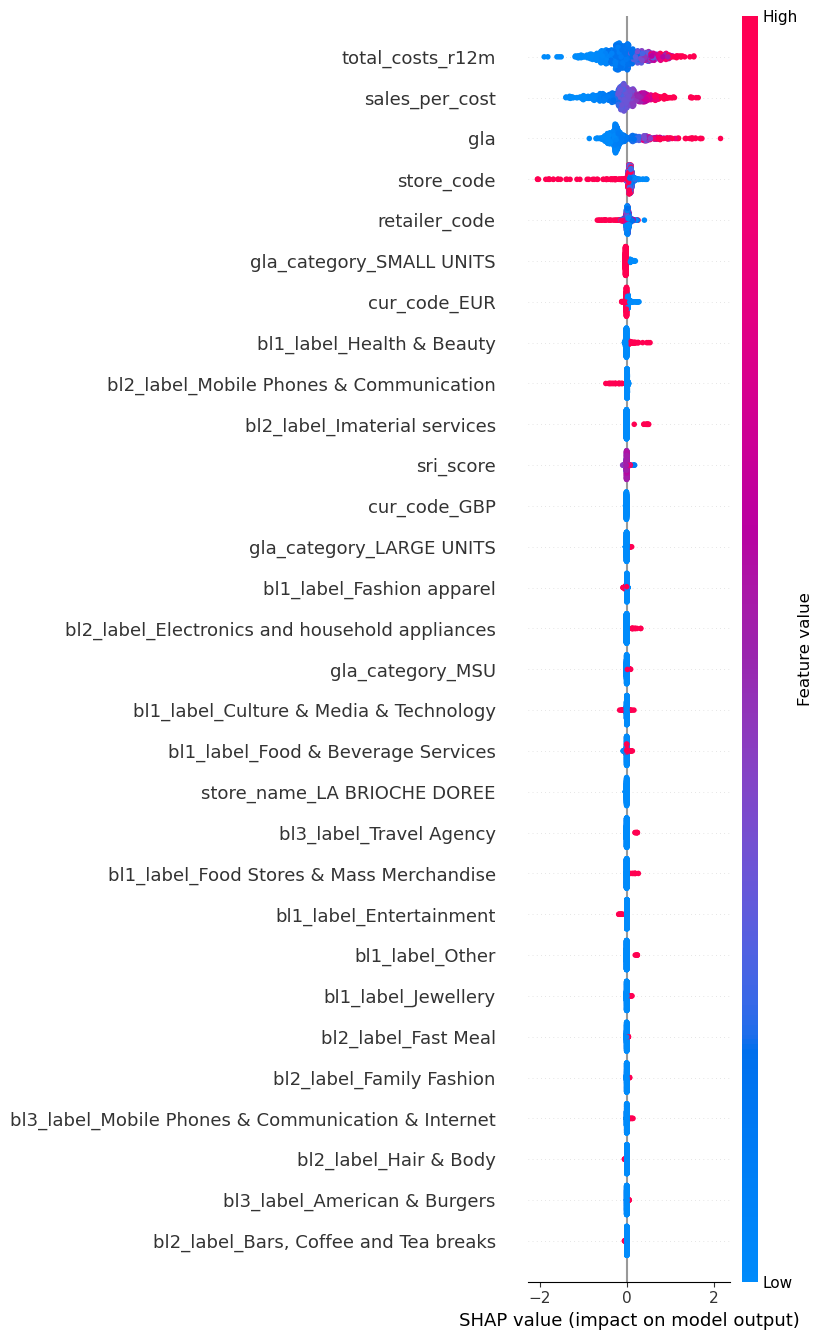

In [16]:
shap.summary_plot(
    shap_values,
    X_val_trans,
    feature_names=feat_names,
    max_display=30
)


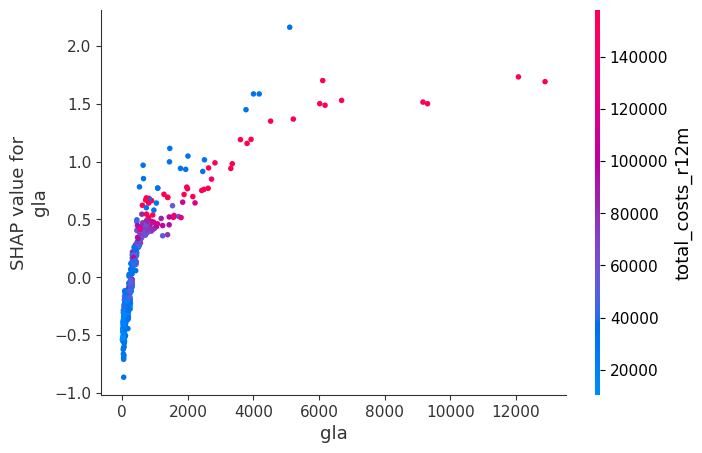

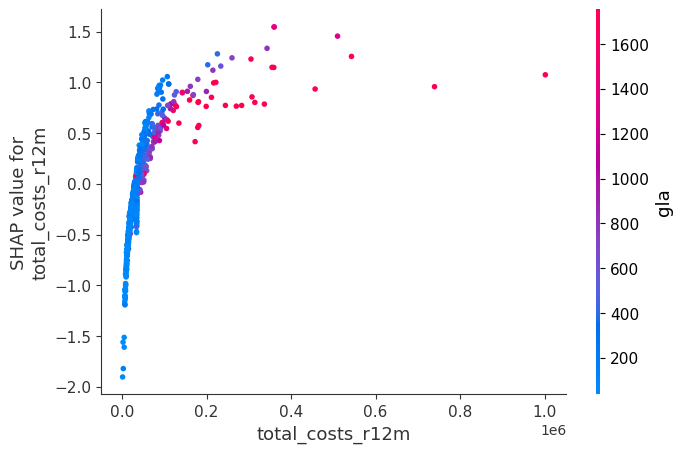

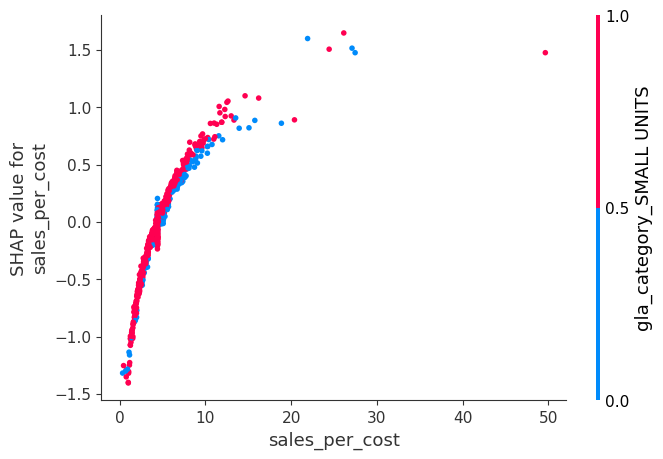

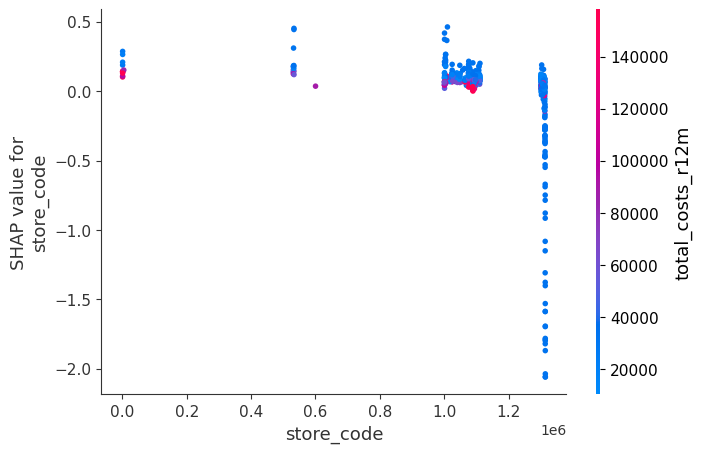

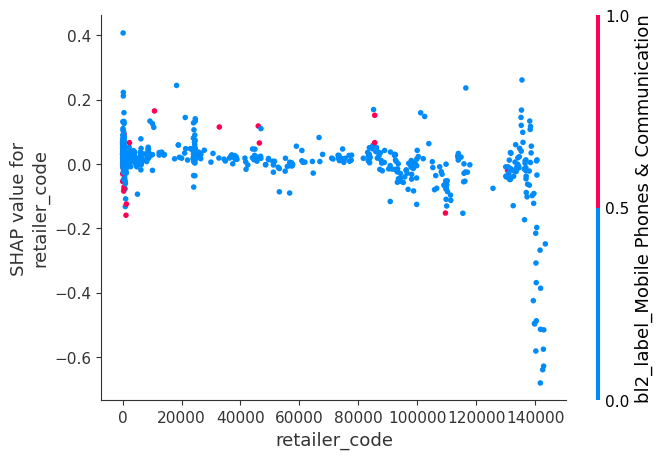

In [17]:
top_features = fi["feature"].head(8).tolist()

for f in top_features[:5]:
    shap.dependence_plot(
        f,
        shap_values,
        X_val_trans,
        feature_names=feat_names,
        show=True
    )


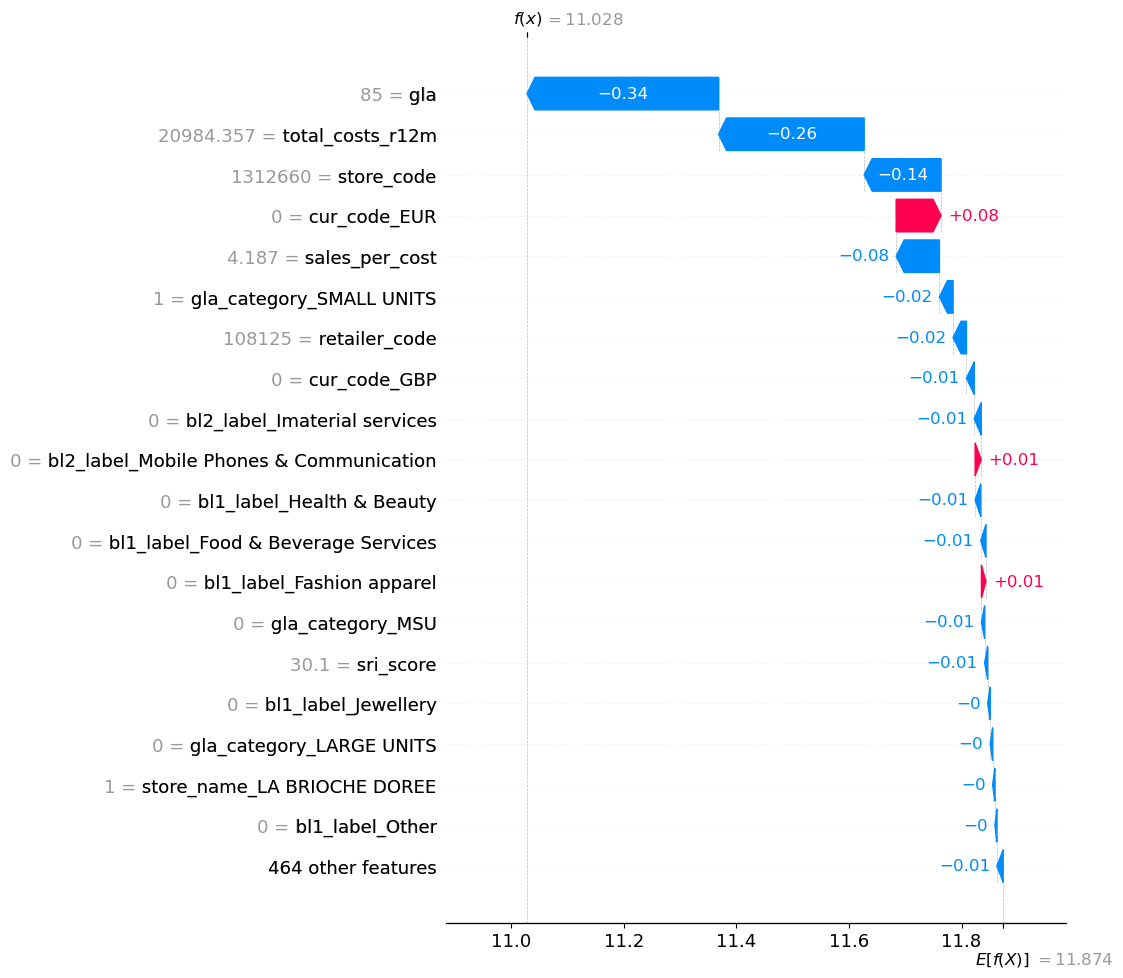

In [18]:
i = 0  # change index inside validation set
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_val_trans[i],
        feature_names=feat_names,
    ),
    max_display=20
)

In [19]:
pred_val_eur = np.expm1(pred_val)
y_val_eur = np.expm1(y_val)

rmse_eur = np.sqrt(mean_squared_error(y_val_eur, pred_val_eur))
mae_eur = np.mean(np.abs(y_val_eur - pred_val_eur))

print("Val RMSE (€):", rmse_eur)
print("Val MAE (€):", mae_eur)

Val RMSE (€): 506782.5011917528
Val MAE (€): 79935.95699372081


In [20]:
# Map transformed feature -> original feature
# Example: "brand_Nike" -> "brand"
orig_from_trans = []
for name in feat_names:
    if name in num_cols:
        orig_from_trans.append(name)
    else:
        # for OHE, pattern is usually "col_value"
        # this heuristic: split on first "_" and take left side if it matches cat column
        left = name.split("_")[0]
        orig_from_trans.append(left if left in cat_cols else left)

orig_from_trans = np.array(orig_from_trans)

# Aggregate |shap| by original feature
abs_shap = np.abs(shap_values)
agg = pd.DataFrame(abs_shap, columns=feat_names).groupby(orig_from_trans, axis=1).mean()

shap_global_by_orig = agg.mean(axis=0).sort_values(ascending=False)
shap_global_by_orig.head(25)


/var/folders/85/wq8vt3b9487397c3mf0t_s980000gn/T/ipykernel_94040/764907386.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  agg = pd.DataFrame(abs_shap, columns=feat_names).groupby(orig_from_trans, axis=1).mean()


total_costs_r12m    0.386834
sales_per_cost      0.346187
store_code          0.137769
gla                 0.096724
retailer_code       0.047027
sri_score           0.010656
cur                 0.010116
bl1                 0.003686
bl2                 0.001051
block               0.000903
bl3                 0.000135
store               0.000019
has_financials      0.000000
has_sri             0.000000
dtype: float64

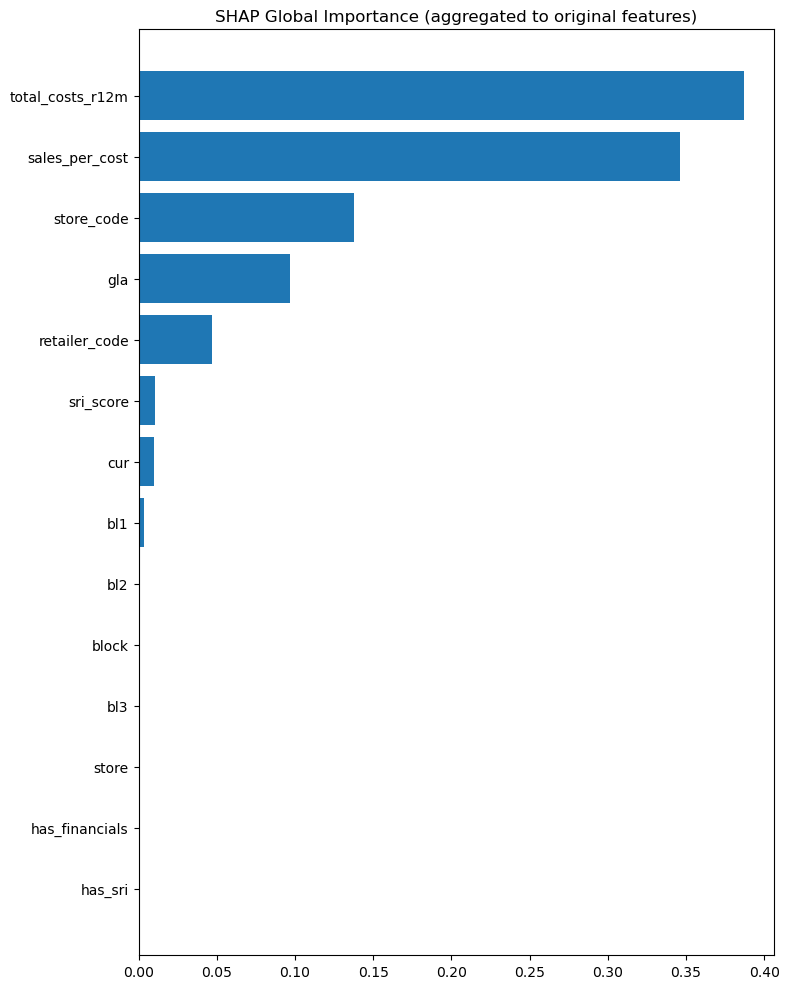

In [21]:
top = shap_global_by_orig.head(25).iloc[::-1]

plt.figure(figsize=(8, 10))
plt.barh(top.index, top.values)
plt.title("SHAP Global Importance (aggregated to original features)")
plt.tight_layout()
plt.show()
